In [1]:
import plot_utils
%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
%run dow_jones_index.py

In [4]:
# xl := X_learn
# xt := X_test
# yl := y_learn
# yt := y_test
xl, xt, yl, yt = getDataForTesting(makeDowJonesColumns(week=False, 
                                                       stock=False, 
                                                       prices=False, 
                                                       volume=True, 
                                                       percent=True, 
                                                       derived=True), 
                                   scale="minmax", 
                                   components=None, 
                                   filterSameDirection=None)

In [5]:
xl.head()

,volume,percent_change_price,percent_change_high,percent_change_low
0,0.158692,0.833841,0.714188,0.984027
1,0.160985,0.477092,0.000000,0.595491
2,0.088528,0.562050,0.147327,0.769789
3,0.097505,0.740355,0.601192,0.980097
4,0.099590,0.926730,0.938823,1.000000


In [6]:
yl.head()

,percent_change_next_weeks_price
0,-4.428490
1,-2.470660
2,1.638310
3,5.933250
4,0.230814


In [7]:
# sxl := X_learn segments
# syl := y_learn segments
sxl, syl = makeDowJonesSegments(xl.join(yl), 
                                1, 
                                3, 
                                xAggFtn=data_utils.makeSegRowAggFtn(np.mean, 4, 3), 
                                yAggFtn=data_utils.makeSegColAggFtn(np.mean, 4, 3))

In [8]:
# sxt := X_test segments
# syt := y_test segments
sxt, syt = makeDowJonesSegments(xt.join(yt),
                                1, 
                                3, 
                                xAggFtn=data_utils.makeSegRowAggFtn(np.mean, 4, 3), 
                                yAggFtn=data_utils.makeSegColAggFtn(np.mean, 4, 3))

In [9]:
sxl = pd.DataFrame(sxl, columns=xl.columns)
syl = pd.DataFrame(syl, columns=yl.columns)
sxt = pd.DataFrame(sxt, columns=sxl.columns)
syt = pd.DataFrame(syt, columns=syl.columns)

In [10]:
sxl.head()

,volume,percent_change_price,percent_change_high,percent_change_low
0,0.136068,0.624328,0.287172,0.783103
1,0.115673,0.593166,0.249507,0.781792
2,0.095208,0.743045,0.562448,0.916629
3,0.089724,0.782121,0.549558,0.949623
4,0.073237,0.749274,0.418945,0.942938


In [11]:
syl.head()

,percent_change_next_weeks_price
0,-1.753613
1,1.700300
2,2.600791
3,1.843839
4,-0.722838


In [12]:
model = findBestEstimator(sxl, 
                          syl, 
                          verbose=True, 
                          kernelRange=['poly', 'rbf'], 
                          degreeRange=[2, 3, 4, 5, 6], 
                          cRange=[0.5, 0.7, 0.9, 1.0, 1.1, 1.2], 
                          gammaRange=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5], 
                          epsilonRange=[0.005, 0.007, 0.009, 0.01, 0.05, 0.09], 
                          validate=True, 
                          scoring=misc_utils.makeProfitLossFtn())

findBestParams:
  scoring=make_scorer(profitScore, greater_is_better=False, calcSign=False)
  gammaRange=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5]
  cRange=[0.5, 0.7, 0.9, 1.0, 1.1, 1.2]
  epsilonRange=[0.005, 0.007, 0.009, 0.01, 0.05, 0.09]
  kernelRange=['poly', 'rbf']
  coef0Range=[0.0]
  degreeRange=[2, 3, 4, 5, 6]
Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed:    4.4s


findBestParams: best_params={'C': 1.2, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
Estimator: SVR(C=1.2, cache_size=200, coef0=0.0, degree=2, epsilon=0.01, gamma=0.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
 Validation Scores: [-0.21581571 -0.11514041 -0.01273597]
Validation Average: -0.11456403109074566


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:   11.1s finished


In [13]:
misc_utils.profitScore(syl, model.predict(sxl))

0.4803947529508497

In [14]:
misc_utils.profitScore(syt, model.predict(sxt))

0.007353034382421697

In [15]:
r2_score(syt, model.predict(sxt))

0.3283459101623265

In [16]:
mean_squared_error(syt, model.predict(sxt))

1.7805672085207378

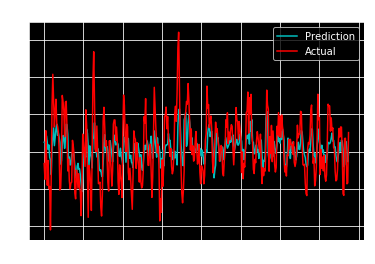

In [17]:
plot_utils.plotPredictVsActual(model.predict(sxt), syt, overlay=True)